<font color="#483D8B">
<h1 align="center"> INET4061 Project : Measuring Performance on Classification Models</h1>
<h3 align="center"> Natalie Hong</h3>
<h3 align="center"> 12/10/18 </h3>
</font>

## Overview

#### Problem Statement: 
The objective is are we want to able to determine if a patient has diabetes based on the diagnositc measurements within the dataset. 

If we are able to determine if a patient has diabetes, we can help patient(s) gain resources to help with their diabetes. We will be using the Pima Indian Diabetes dataset to help us answer the problem. This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases.

A logistic regression classification model will be created then we will measure the performance to see how trustworthy the results are. A random forest classification model will be created to compare results to see which is more trustworthy. From both models, we will see which performs better. Some performance measures that will be compared are accuracy, specificity, sensitivity, precision, cross validation, and more. From the two models, we can see which model performs better with the dataset.

Youtube link: https://youtu.be/HSnQtXg2pzo

In [1]:
import pandas as pd
from sklearn import model_selection
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import graphviz
from sklearn.tree import export_graphviz

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data

The dataset that is being used is the Pima Indian Diabetes. There are several medical indicators and one target variable, outcome (label). <br/>
The variables are: <br/>
* pregnant - number of pregnancies <br/>
* glucose - glucose concentration for 2 hours in a oral glucose tolerance test <br/>
* blood pressure - diastolic blood pressure (mm Hg) <br/>
* skin - skin thickness (mm) <br/>
* insulin - 2 hour serum insulin (mu U/ml) <br/>
* BMI - body mass index (weight in kg/(height in m)^2) <br/>
* pedigree - diabetes pedigree function <br/>
* age - age (years) <br/>
* label - outcome (1 or 0)

#### Data Characteristics:
* data is only about female patients
* Pima Indian heritage
* 21 years or older
* attributes are numeric
* data can potentially contain invalid or null values
* total entries in the database are 768

In [2]:
url = "/Users/nataliehong/Downloads/pima-indians-diabetes.csv"

col_names = ['pregnant', 'glucose', 'bloodpressure', 'skin', 'insulin', 'BMI', 'pedigree', 'Age','label']

diabetes = pd.read_csv(url, header=None, names=col_names)

diabetes.head()

,pregnant,glucose,bloodpressure,skin,insulin,BMI,pedigree,Age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
diabetes.describe()

,pregnant,glucose,bloodpressure,skin,insulin,BMI,pedigree,Age,label
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


The mean number of each column tells us the average score for each column. There is also the standard deviation, min/max, and the percentages for each column. 

## Exploratory Data Analysis

The outcome (label) determines whether someone has diabetes or not. Once we can determine factors that contribute to diabetes, we will be able to provide resources for the ones who have it. But it's also important that both sides are even in numbers. So it's balanced when we test it.

In [4]:
feature_cols = ['pregnant', 'glucose', 'insulin', 'BMI', 'Age']

X = diabetes[feature_cols]

y = diabetes.label

When choosing the columns to use, I thought of which ones were important in determining diabetes. 
* Pregnancies could help us determine the chance of diabetes because women are at risk of having gestational diabetes during pregnancy and that's a factor that can lead to type 2 diabetes.
* One of the most important features is glucose. Glucose is important because if we have excessive amounts of glucose, then we are at risk for type 2 diabetes.
* Not having enough insulin amounts can help us determine if someone has diabetes.
* Body mass index can help us determine diabetes because the more fatty tissue you have, the more resistant your cells become to insulin.
* Lastly, age can help determine diabetes. Your risk increases as you get older.

In [5]:
#Checking Class Balance on dataset
df = diabetes

cnt_no_db = len(df[df['label'] == 0])
cnt_db = len(df[df['label'] == 1])

print(cnt_db, 'Pima Indian Women have diabetes and', cnt_no_db,'do not have it')
diabetes.groupby("label").size()

268 Pima Indian Women have diabetes and 500 do not have it


label
0    500
1    268
dtype: int64

In [6]:
# Splitting into train and test sets 
#split ratio is 80/20
split = .8
train_i = int(len(df) * split)

train = df[:train_i]
test = df[train_i:]

In [7]:
#most patients don't have diabetes
majority = train[train['label'] == 0]
minority = train[train['label'] == 1]

train_bal = pd.concat([minority, 
                       majority.head(len(minority))])

In [8]:
#Balancing class
train_X = train_bal.drop('label',axis=1)
train_y = train_bal['label']

test_X = test.drop('label',axis=1)
test_y = test['label']

print(len(train_X), 'Pima Indian Women have diabetes and', len(train_y),'do not have it')

426 Pima Indian Women have diabetes and 426 do not have it


In [9]:
#checking to see if all data is in the dataset
diabetes.isnull().sum()

pregnant         0
glucose          0
bloodpressure    0
skin             0
insulin          0
BMI              0
pedigree         0
Age              0
label            0
dtype: int64

In [10]:
diabetes.corr()

,pregnant,glucose,bloodpressure,skin,insulin,BMI,pedigree,Age,label
pregnant,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
bloodpressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
skin,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
pedigree,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
label,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


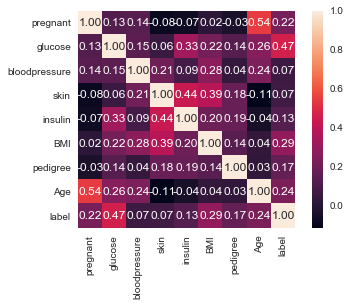

In [63]:
cols = ['pregnant','glucose','bloodpressure','skin','insulin','BMI','pedigree','Age', 'label']
cm = np.corrcoef(diabetes[cols].values.T)
sns.set(font_scale=1.0)
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size': 12},yticklabels=cols,xticklabels=cols)
plt.show()

Here is a correlation between all features to each other. You can see that some features have a negative number, showing a strong negative correlation. Most show correlation of 0.2 or less. Below is a pairplot version as a visualization.

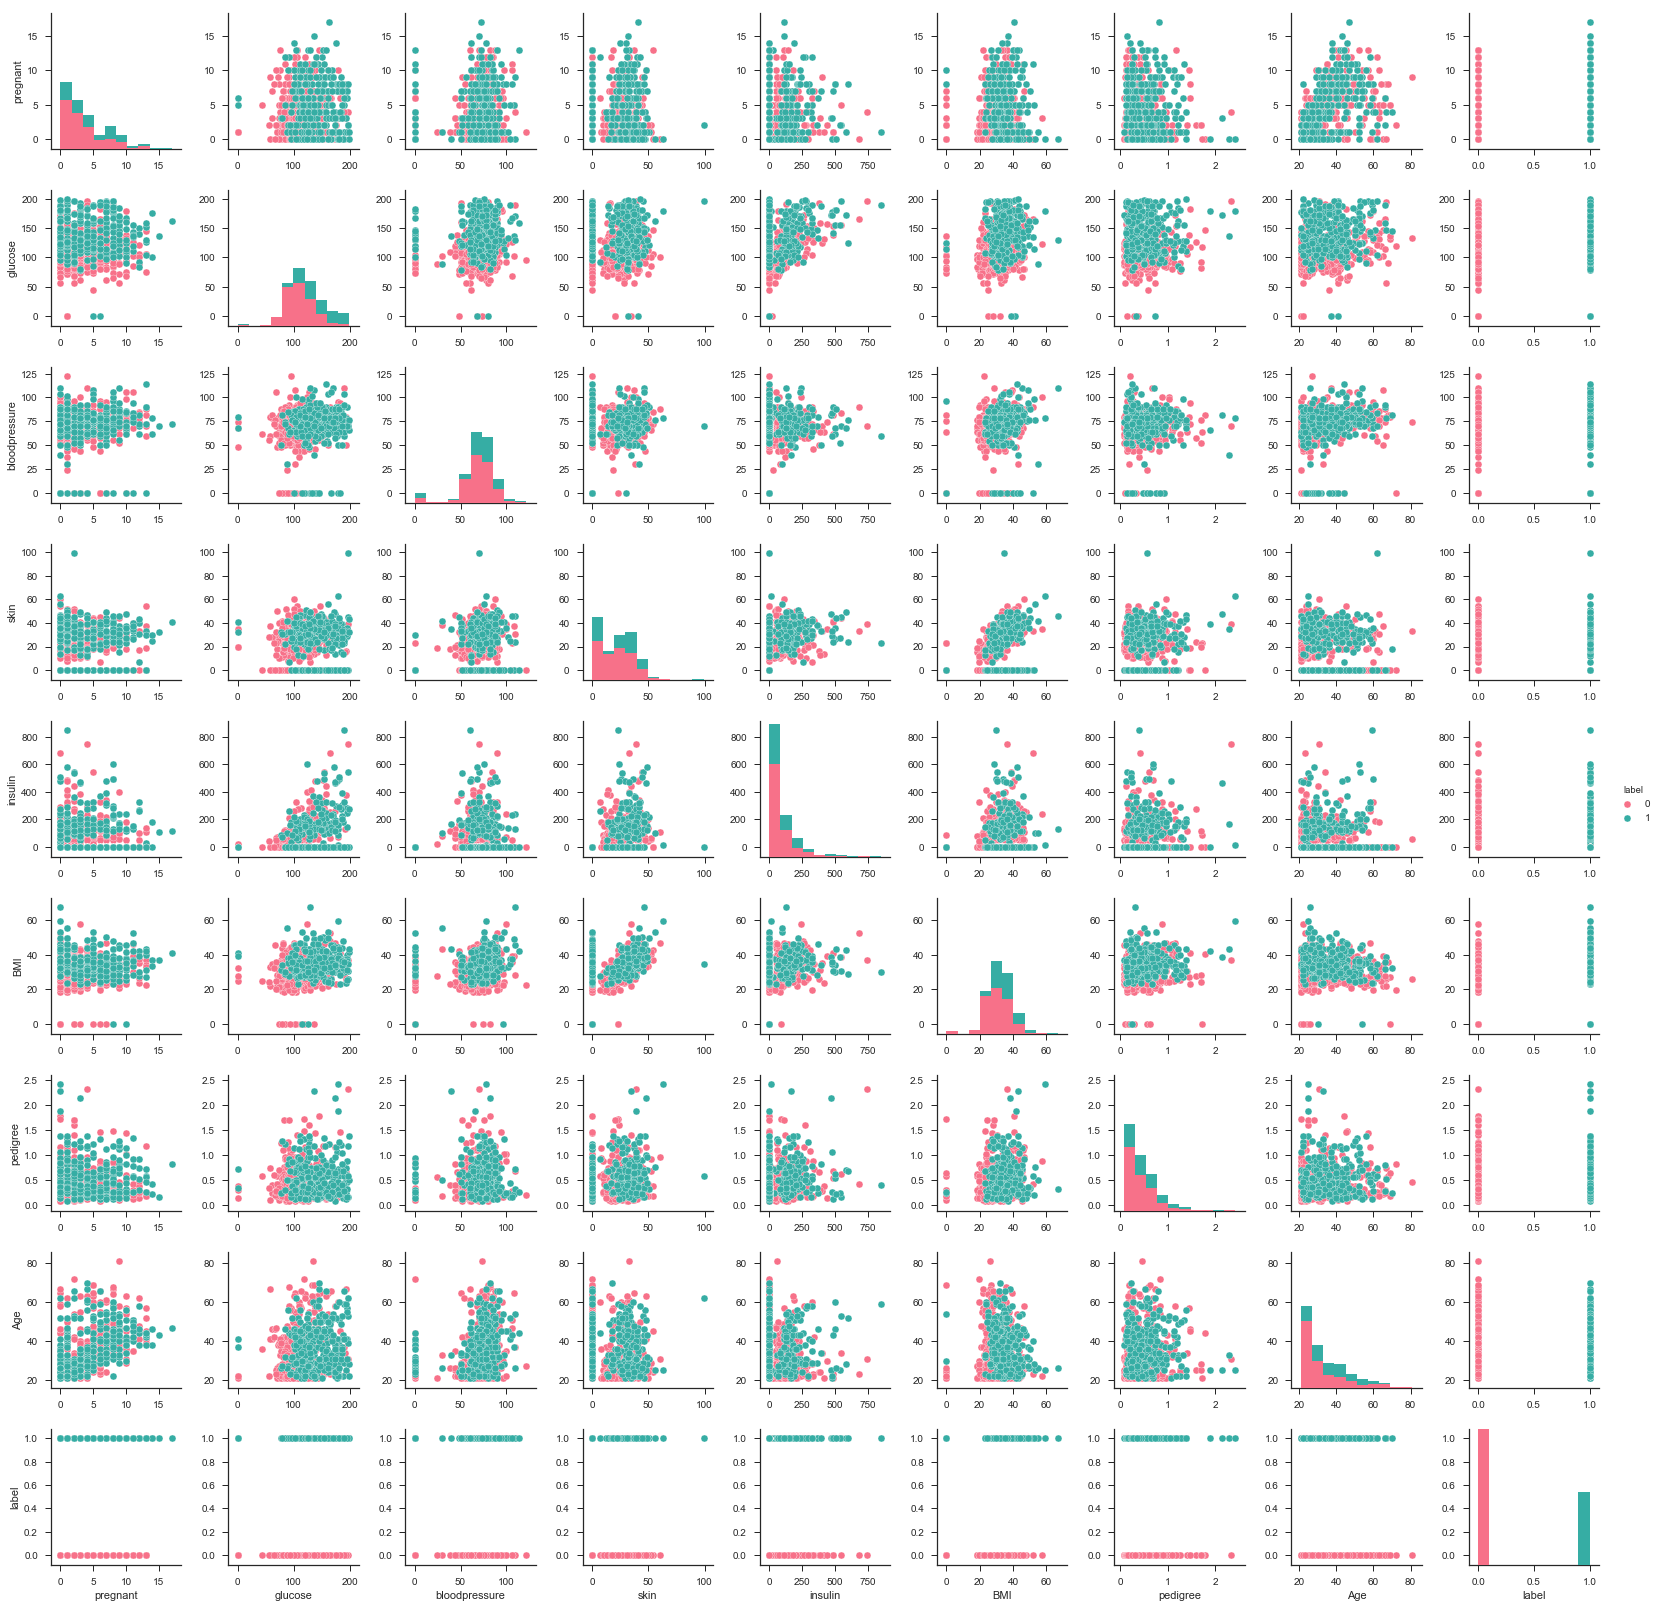

In [11]:
#Pairplot to show all features and the correlation of having
#or not having diabetes (0 or 1)
sns.set(style='ticks')
plt.figure(figsize=(20,20))
sns.pairplot(diabetes, hue='label', palette="husl")

## Models

Two classification models created are a logistic regression and random forest. We will compare the performance on these two models to determine which one has a better accuracy of the data in the database. Some ways to measure the data is through confusion matrix, ROC curve, adjusting classification threshold, and AUC. There's also a classification report from sklearn that show some measurements together.

### Logistic Regression Model

In [12]:
# instantiate model
logreg = LogisticRegression()

# fit model
logreg.fit(train_X, train_y)
print(logreg)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [13]:
#predicted values for testing data 
y_pred_class = logreg.predict(test_X)

### Random Forest Model

In [14]:
rf_model = RandomForestClassifier(random_state = 42) # Create random forest object
rf_model.fit(train_X, train_y.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [15]:
#predicted values for testing data 
y_predict_class = rf_model.predict(test_X)

### Performance Metrics on Logistic Regression and Random Forest Models
* Confusion Matrix
* Classification Threshold
* ROC Curve
* AUC
* Classification Report

#### Confusion Matrix for Logistic Regression

This is a presentation of the accuracy of a model with two or more  classes. The table presents predictions on the x-asix and accuracy outcomes on the y-axis. 

* Accuracy : the proportion of the total number of predictions that were correct.
* Positive Predictive Value or Precision : the proportion of positive cases that were correctly identified.
* Negative Predictive Value : the proportion of negative cases that were correctly identified.
* Sensitivity or Recall : the proportion of actual positive cases which are correctly identified.
* Specificity : the proportion of actual negative cases which are correctly identified.

In [16]:
#Confusion matrix for Logistic Regression
confusion_matrix=metrics.confusion_matrix(test_y, y_pred_class)
print(confusion_matrix)

[[82 17]
 [13 42]]


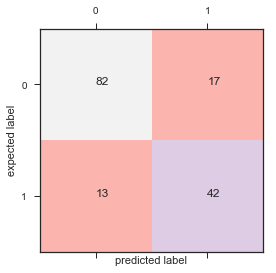

In [17]:
#Visualization of the confusion matrix
plt.figure()
plt.matshow(confusion_matrix, cmap='Pastel1')

for x in range(0, 2):
    for y in range(0, 2):
        plt.text(x, y, confusion_matrix[y, x])
        
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()

True Negative = 82
* True negatives are the cases when the actual class of the data point was 0 (False) and the predicted is also 0 (False) 

False Positive = 17
* False positives are the cases when the actual class of the data point was 0(False) and the predicted is 1(True). False is because the model has predicted incorrectly and positive because the class predicted was a positive one. (1) 

False Negative = 13
* False negatives are the cases when the actual class of the data point was 1(True) and the predicted is 0(False). False is because the model has predicted incorrectly and negative because the class predicted was a negative one. (0) 

True Positive = 42
* True positives are the cases when the actual class of the data point was 1(True) and the predicted is also 1(True)

In [18]:
confusion = metrics.confusion_matrix(test_y, y_pred_class)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[82 17]
 [13 42]]


**Classification Accuracy:** Overall, how often is the classifier correct?

In [19]:
print("Accuracy on training set: {:.3f}".format(logreg.score(train_X,train_y)))
print("Accuracy on test set: {:.3f}".format(logreg.score(test_X,test_y)))

Accuracy on training set: 0.735
Accuracy on test set: 0.805


**Classification Error:** Overall, how often is the classifier incorrect?

Also can be considered the misclassification rate.

In [20]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)

0.194805194805


**Sensitivity:**  When the actual value is positive, how often is the prediction correct?

* Something we want to maximize
* How "sensitive" is the classifier to detecting positive instances?
* Also known as "True Positive Rate" or "Recall"
* TP / all positive
    * all positive = TP + FN

In [21]:
sensitivity = TP / float(FN + TP)

print(sensitivity)

0.763636363636


**Specificity:** When the actual value is negative, how often is the prediction correct?

* Something we want to maximize
* How "specific" (or "selective") is the classifier in predicting positive instances?
* TN / all negative
    * all negative = TN + FP

In [22]:
specificity = TN / (TN + FP)

print(specificity)

0.828282828283


**False Positive Rate:** When the actual value is negative, how often is the prediction incorrect?

In [23]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)

0.171717171717


**Precision:** When a positive value is predicted, how often is the prediction correct?

* How "precise" is the classifier when predicting positive instances?

In [24]:
precision = TP / float(TP + FP)

print(metrics.precision_score(test_y, y_pred_class))

0.71186440678


#### Confusion Matrix for Random Forest Model

In [25]:
#Confusion Matrix for Random Forest
confusion_matrix2=metrics.confusion_matrix(test_y, y_predict_class)
print(confusion_matrix2)

[[79 20]
 [23 32]]


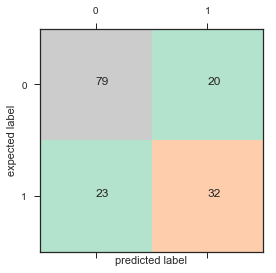

In [57]:
#Visualization of the confusion matrix
plt.figure()
plt.matshow(confusion_matrix2, cmap='Pastel2')

for x in range(0, 2):
    for y in range(0, 2):
        plt.text(x, y, confusion_matrix2[y, x])
        
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()

* True Negative: (79) we correctly predicted that they don't have diabetes
* False Positive: (20) we incorrectly predicted that they do have diabetes
* False Negative: (23) we incorrectly predicted that they don't have diabetes
* True Positive: (32) we correctly predicted that they do have diabetes

In [27]:
confusion = metrics.confusion_matrix(test_y, y_predict_class)
print(confusion)
#[row, column]
TP2 = confusion[1, 1]
TN2 = confusion[0, 0]
FP2 = confusion[0, 1]
FN2 = confusion[1, 0]

[[79 20]
 [23 32]]


**Classification Accuracy:** Overall, how often is the classifier correct?

In [28]:
#Accuracy score 
print("Accuracy on training set: {:.3f}".format(rf_model.score(train_X,train_y)))
print("Accuracy on test set: {:.3f}".format(rf_model.score(test_X,test_y)))

Accuracy on training set: 0.981
Accuracy on test set: 0.721


**Classification Error:** Overall, how often is the classifier incorrect?

Also can be considered the misclassification rate.

In [29]:
classification_error = (FP2 + FN2) / float(TP2 + TN2 + FP2 + FN2)

print(classification_error)

0.279220779221


**Sensitivity:**  When the actual value is positive, how often is the prediction correct?

* Something we want to maximize
* How "sensitive" is the classifier to detecting positive instances?
* Also known as "True Positive Rate" or "Recall"
* TP / all positive
    * all positive = TP + FN

In [30]:
sensitivity2 = TP2 / float(FN2 + TP2)

print(sensitivity2)

0.581818181818


**Specificity:** When the actual value is negative, how often is the prediction correct?

* Something we want to maximize
* How "specific" (or "selective") is the classifier in predicting positive instances?
* TN / all negative
    * all negative = TN + FP

In [31]:
specificity2 = TN2 / (TN2 + FP2)

print(specificity2)

0.79797979798


**False Positive Rate:** When the actual value is negative, how often is the prediction incorrect?

In [32]:
false_positive_rate = FP2 / float(TN2 + FP2)

print(false_positive_rate)

0.20202020202


**Precision:** When a positive value is predicted, how often is the prediction correct?

* How "precise" is the classifier when predicting positive instances?

In [33]:
precision = TP / float(TP + FP)

print(metrics.precision_score(test_y, y_predict_class))

0.615384615385


#### Classification Threshold

In [34]:
# print the first 10 predicted probabilities of class membership
print('Logistic Regression')
save_predictions_proba = logreg.predict_proba(test_X)[0: 10]  
print(save_predictions_proba)
y_pred_prob = logreg.predict_proba(test_X)[:, 1]
print(" ")
print('Random Forest')
rf_save_predictions_proba = rf_model.predict_proba(test_X)[0: 10]
y_predict_prob = rf_model.predict_proba(test_X)[:, 1]
print(rf_save_predictions_proba)

Logistic Regression
[[ 0.23688679  0.76311321]
 [ 0.76286189  0.23713811]
 [ 0.71261683  0.28738317]
 [ 0.90217494  0.09782506]
 [ 0.37397347  0.62602653]
 [ 0.43847659  0.56152341]
 [ 0.64984147  0.35015853]
 [ 0.62659787  0.37340213]
 [ 0.0853543   0.9146457 ]
 [ 0.65194685  0.34805315]]
 
Random Forest
[[ 0.2  0.8]
 [ 0.7  0.3]
 [ 0.4  0.6]
 [ 0.9  0.1]
 [ 0.5  0.5]
 [ 0.4  0.6]
 [ 0.3  0.7]
 [ 1.   0. ]
 [ 0.2  0.8]
 [ 0.8  0.2]]


* In each row the numbers sum up to 1
* There are 2 columns for 2 classes ('label' = 0 and 'label' = 1)
    + column 0: predicted probability that each observation is a member of class 0
    + column 1: predicted probability that each observation is a member of class 1
* Choose the class with the highest probability (classification threshold = 0.5)
    + Class 1 is predicted if probability > 0.5
    + Class 0 is predicted if probability < 0.5
* save_predictions_proba process
    + Predicts the probabilities
    + Choose the class with the highest probability

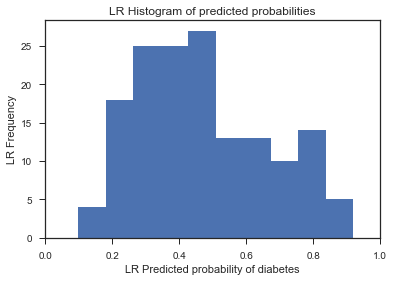

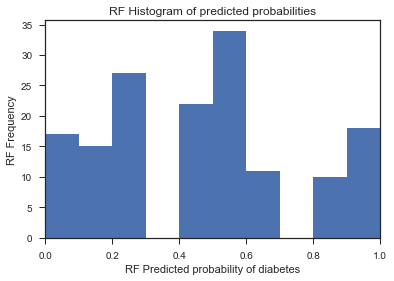

In [35]:
# histogram of predicted probabilities

save_predictions_proba = logreg.predict_proba(test_X)[:, 1]  # column 1
rf_save_predictions_proba = rf_model.predict_proba(test_X)[:, 1]

plt.hist(save_predictions_proba, bins=10)
plt.xlim(0,1) # x-axis limit from 0 to 1
plt.title('LR Histogram of predicted probabilities')
plt.xlabel('LR Predicted probability of diabetes')
plt.ylabel('LR Frequency')
plt.show()

plt.hist(rf_save_predictions_proba, bins=10)
plt.xlim(0,1) # x-axis limit from 0 to 1
plt.title('RF Histogram of predicted probabilities')
plt.xlabel('RF Predicted probability of diabetes')
plt.ylabel('RF Frequency')
plt.show()

Logistic Regression:
* Just a small number of observations with probability > 0.5, most observations have a probability < 0.5 and would be predicted "no diabetes" in our case. We can increase the sensitivity (increase number of TP) of the classifier by decreasing the threshold for predicting diabetes.

Random Forest:
* It seems that there is good amount of observations with probability < 0.5 and there are some probabilities that weren't predicted.

Solution: 
* Decrease the threshold for predicting diabetes that increase the sensitivity of the classifier
* This would increase the number of TP
* More sensitive to positive instances


In [36]:
# predict diabetes if the predicted probability is greater than 0.3
from sklearn.preprocessing import binarize

# it will return 1 for all values above 0.3 and 0 otherwise
# results are 2D so we slice out the first column
lr_prediction2 = binarize(save_predictions_proba.reshape(-1, 1), 0.3)  # [0]
rf_prediction2 = binarize(rf_save_predictions_proba.reshape(-1, 1), 0.3)  # [0]

In [37]:
# LR New Confusion Matrix 
lr_confusion_matrix2 = metrics.confusion_matrix(test_y, lr_prediction2)
lr_confusion_matrix2

# previous confusion matrix
# array [[82 17]
#       [13 42]]

array([[37, 62],
       [ 0, 55]])

In [38]:
# RF New Confusion Matrix
rf_confusion_matrix2 = metrics.confusion_matrix(test_y, rf_prediction2)
rf_confusion_matrix2

# previous confusion matrix
# array [[79 20]
#       [23 32]]

array([[54, 45],
       [ 5, 50]])

With the new confusion matrix for both models, we can see that there is an increase in true positive results and decrease in false negative results. It's the same for the top row also where left column results are moving to the right.

In [39]:
TP = lr_confusion_matrix2[1, 1]
TN = lr_confusion_matrix2[0, 0]
FP = lr_confusion_matrix2[0, 1]
FN = lr_confusion_matrix2[1, 0]

print('Logistic Regression')
print("new Sensitivity: %.4f" % (TP / float(TP + FN)))
print("new Specificity: %.4f" % (TN / float(TN + FP)))
print("old Sensitivity: %.4f" % (sensitivity))
print("old Specificity: %.4f" % (specificity))
print(" ")

TP2 = rf_confusion_matrix2[1, 1]
TN2 = rf_confusion_matrix2[0, 0]
FP2 = rf_confusion_matrix2[0, 1]
FN2 = rf_confusion_matrix2[1, 0]

print('Random Forest')
print("new Sensitivity: %.4f" % (TP2 / float(TP2 + FN2)))
print("new Specificity: %.4f" % (TN2 / float(TN2 + FP2)))
print("old Sensitivity: %.4f" % (sensitivity2))
print("old Specificity: %.4f" % (specificity2))

Logistic Regression
new Sensitivity: 1.0000
new Specificity: 0.3737
old Sensitivity: 0.7636
old Specificity: 0.8283
 
Random Forest
new Sensitivity: 0.9091
new Specificity: 0.5455
old Sensitivity: 0.5818
old Specificity: 0.7980


For the new sensitivity and specificity in logistic regression, we can see an increase in one and decrease in another. Sensitivity now has a score of 1.000 which menas that when the actual value is positive, it's 100% correct. But for the random forest model, it the sensitivity decreased as the specificity increased. There will be a more accurate prediction when the actual value is negative rather than positive.

#### Receiver Operating Characteristic (ROC) Curves
* input: IMPORTANT: first argument is true values, second argument is predicted probabilities
* We do not use y_pred_class, because it will give incorrect results without generating an error
* output: FPR, TPR, thresholds
* FPR: false positive rate
* TPR: true positive rate

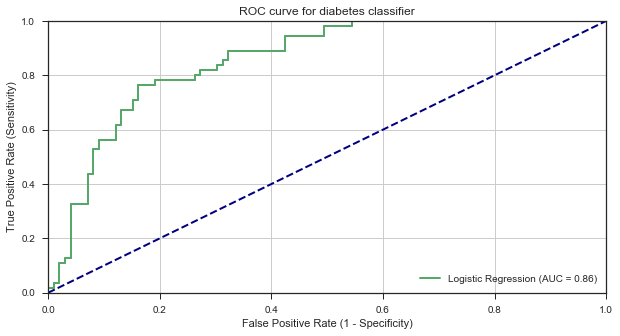

In [40]:
# ROC curve for Logistic Regression
save_predictions_proba = logreg.predict_proba(test_X)[:, 1]  # column 1
FPR, TPR, thresholds = roc_curve(test_y, save_predictions_proba)

plt.figure(figsize=(10,5))  # figsize in inches
plt.plot(FPR, TPR)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 50%  
plt.plot(FPR, TPR, lw=2, label='Logistic Regression (AUC = %0.2f)' % auc(FPR, TPR))
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.legend(loc="lower right")

In [41]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', TPR[thresholds > threshold][-1])
    print('Specificity:', 1 - FPR[thresholds > threshold][-1])
    print(" ")
evaluate_threshold(0.5)
evaluate_threshold(0.3)

Sensitivity: 0.763636363636
Specificity: 0.838383838384
 
Sensitivity: 1.0
Specificity: 0.454545454545
 


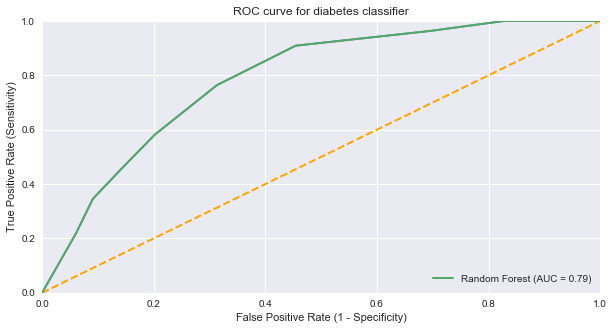

In [66]:
# ROC curve for Random Forest
rf_save_predictions_proba = rf_model.predict_proba(test_X)[:, 1]  # column 1
FPR2, TPR2, thresholds2 = roc_curve(test_y, rf_save_predictions_proba)

plt.figure(figsize=(10,5))  # figsize in inches
plt.plot(FPR2, TPR2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')  # 50%  
plt.plot(FPR2, TPR2, lw=2, label='Random Forest (AUC = %0.2f)' % auc(FPR2, TPR2))
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.legend(loc="lower right")

In [51]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', TPR2[thresholds2 > threshold][-1])
    print('Specificity:', 1 - FPR2[thresholds2 > threshold][-1])
    print(" ")
evaluate_threshold(0.5)
evaluate_threshold(0.3)

Sensitivity: 0.581818181818
Specificity: 0.79797979798
 
Sensitivity: 0.909090909091
Specificity: 0.545454545455
 


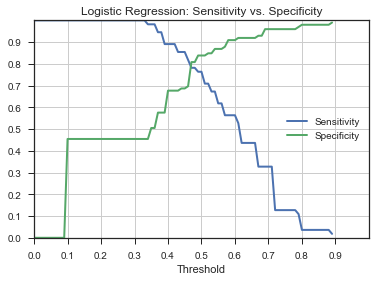

In [53]:
spec = []
sens = []
thres = []

threshold = 0.00
for x in range(0, 90):
    thres.append(threshold)
    sens.append(TPR[thresholds > threshold][-1])
    spec.append(1 - FPR[thresholds > threshold][-1])
    threshold += 0.01
    
plt.plot(thres, sens, lw=2, label='Sensitivity')
plt.plot(thres, spec, lw=2, label='Specificity')
ax = plt.gca()
ax.set_xticks(np.arange(0, 1, 0.1))
ax.set_yticks(np.arange(0, 1, 0.1))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Logistic Regression: Sensitivity vs. Specificity')
plt.xlabel('Threshold')
plt.grid(True)
plt.legend(loc="center right")

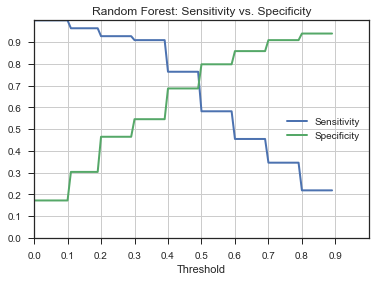

In [55]:
spec = []
sens = []
thres = []

threshold = 0.00
for x in range(0, 90):
    thres.append(threshold)
    sens.append(TPR2[thresholds2 > threshold][-1])
    spec.append(1 - FPR2[thresholds2 > threshold][-1])
    threshold += 0.01
    
plt.plot(thres, sens, lw=2, label='Sensitivity')
plt.plot(thres, spec, lw=2, label='Specificity')
ax = plt.gca()
ax.set_xticks(np.arange(0, 1, 0.1))
ax.set_yticks(np.arange(0, 1, 0.1))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Random Forest: Sensitivity vs. Specificity')
plt.xlabel('Threshold')
plt.grid(True)
plt.legend(loc="center right")

By looking at the Sensitivity vs. Specificity graphs, we can see that having a threshold between about 0.47 and 0.5, the sensitivity and specificity score is about the same. 

#### AUC

AUC is the percentage of the ROC plot that is underneath the curve:

* AUC is useful as a single number summary of classifier performance
* Higher value = better classifier
* AUC of 0.5 is like tossing a coin
* If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a higher predicted probability to the positive observation
* AUC is useful even when there is high class imbalance (unlike classification accuracy)

In [44]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
print('Logistic Regression')
print(metrics.roc_auc_score(test_y, y_pred_prob))
print(" ")

print('Random Forest')
print(metrics.roc_auc_score(test_y, y_predict_prob))

Logistic Regression
0.856014692378
 
Random Forest
0.787419651056


In [48]:
Y = diabetes.label

# calculate cross-validated AUC
print('Logistic Regression')
print(cross_val_score(logreg, X, Y, cv=10, scoring='roc_auc').mean())
print(" ")

print('Random Forest')
print(cross_val_score(rf_model, X, Y, cv=10, scoring='roc_auc').mean())

Logistic Regression
0.820216524217
 
Random Forest
0.788719373219


#### Logistic Regression Classification Report

In [49]:
print("Confusion Matrix")
# Note the use of labels for set 0=True to upper left and 1=False to lower left
print("{0}".format(metrics.confusion_matrix(test_y, y_pred_class, labels=[0, 1])))
print("")

print("Classification Report")
report = classification_report(test_y, y_pred_class)
print(report)

Confusion Matrix
[[82 17]
 [13 42]]

Classification Report
             precision    recall  f1-score   support

          0       0.86      0.83      0.85        99
          1       0.71      0.76      0.74        55

avg / total       0.81      0.81      0.81       154



#### Random Forest Classification Report

In [64]:
print("Confusion Matrix")
print("{0}".format(metrics.confusion_matrix(test_y, y_predict_class, labels=[0, 1])))
print("")

print("Classification Report")
print(metrics.classification_report(test_y, y_predict_class, labels=[1, 0]))

Confusion Matrix
[[79 20]
 [23 32]]

Classification Report
             precision    recall  f1-score   support

          1       0.62      0.58      0.60        55
          0       0.77      0.80      0.79        99

avg / total       0.72      0.72      0.72       154



## Conclusion

The domain question that we want to analyze is "based on diagnostic measurements, how can we predict that whether a patient has diabetes?" 

Two models were created to use the data set and measure classification methods. One model created is the logistic regression model. This model can be used to describe the data and explain the relationship between one or more nomial, ordinal, inteval or ratio-level independent variables. The other model created is the random forest model. Random Forest is flexible and easy to use, it builds multiple decision trees and merges them together ot get a more accurate and stable prediction. Instead of searching for the most important feature while splitting a node, it searches for the best feature among a random subset of features. This results in a wide diversity that generally results in a better model.

There were many performance metrics to compare both models: confusion matrix, classification threshold, ROC/AUC, and a classification report from sklearn. With these metrics, I was able to identify which of the two models had a better performance. I thought that the confusion matrix was most useful as I analyzed both models. Acurracy helped show the how accurate the training and test sets were.  Sensitivity and specificity metrics seem to be used in other methods too. The classification report is also useful because it shows the scores of metrics where you can compare.

I would recommend to use the logistic regression model when evaluating the results of the data set and for that model to give more accurate results for predicting patients that have/would have eventually diabetes. 

There are some improvements I would make to my project. Currently, I'm only comparing two models to each other when there are more classification models that I can add to compare. Then I would have a bigger selection of models to measure performance on and pick the best one. I also found that there are different cross validation methods that I can use to improve the performance of my models.

References: 
* https://www.kaggle.com/rnmehta5/pima-indian-diabetes-binary-classification
* https://www.kaggle.com/lucky1/pima-indians-diabetes-dataset-part-1
* https://medium.com/greyatom/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b
* https://github.com/CarlousF/pima-indian-diabetes/blob/master/Pima-Prediction.ipynb
* https://www.ritchieng.com/machine-learning-evaluate-classification-model
* https://github.com/KriAga/Pima-Indians-Diabetes-Dataset-Classification/blob/master/Final.ipynb

Data source: 
* https://www.kaggle.com/uciml/pima-indians-diabetes-database
* information about data: https://data.world/data-society/pima-indians-diabetes-database